##


#### To create the dataframes and files needed for our analysis, make sure that:

Make sure you have the following files in `data/raw`:
  1. [full_database.xml](https://drive.google.com/file/d/1149kYVkazq67e0vuv-_4APyqVX6yyh2p), which will represent the XML version of the DrugBank
  2. [BindingDB_All.tsv](https://www.bindingdb.org/bind/downloads/BindingDB_All_202411_tsv.zip), which will represent the tsv version of the BindingDB

### Imports

In [64]:
import os
import gc
import re
import requests
import time
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from tqdm import tqdm
import pandas as pd
from concurrent.futures import ThreadPoolExecutor

from drugbank_XML_drugparser import DrugParser
from drugbank_bindingdb_merger import DrugBank_BindingDB_Merger
from preprocessing import Preprocessing, ColumnClean

from data_paths import *

%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Parsing and cleaning BindingDB

In [65]:
if os.path.exists(BINDINGDB_CLEAN):
    print("BindingDB clean exists...")
    clean_binding_df = pd.read_pickle(BINDINGDB_CLEAN)
else:
    print("Creating clean BindingDB...")
    def load_BindingDB(file_path, cols):
        return pd.read_csv(file_path, sep='\t', header=0, usecols=cols)

    """
    This method srips all non-numeric characters from the value.

    For example, the temperature is always given as 12C or 14.2C, so we remove the C.

    In come cases, mesured values are given as >10000 or <.01. In these cases, we just take the bound, as it is still better then loosing all the information by replacing it with NA.
    """
    def keep_just_numeric(value):
        if type(value) != str:
            if type(value) == float or type(value) == int:
                return value
            else:
                return pd.NA

        ## All non-numeric characters (except the decimal .) should be replaced
        cleaned_val = re.sub(r'[^\d.]+','', str(value)) 
        if(cleaned_val == ''): # It didn't contain any number?
            return pd.NA
        return float(cleaned_val)

    def parse_int(value):
        try:
            return int(value)
        except:
            return pd.NA
    # First, we specify which 
    bdb_preprocessor = Preprocessing(
        [
            ColumnClean('Ki (nM)', 'ki', clean=keep_just_numeric),
            ColumnClean('pH', 'ph', clean=keep_just_numeric),
            ColumnClean('Temp (C)', 'temp', clean=keep_just_numeric),
            ColumnClean('IC50 (nM)', 'ic50', clean=keep_just_numeric),
            ColumnClean('Kd (nM)', 'kd', clean=keep_just_numeric),
            ColumnClean('kon (M-1-s-1)', 'kon', clean=keep_just_numeric),

            # These columns are supposed to contain strings.
            ColumnClean('Article DOI', 'doi'),

            # We use these IDs to join bindingDB and drugbank
            ColumnClean('PubChem CID', 'pubchem_cid'),
            ColumnClean('ChEBI ID of Ligand', 'chebi_id'),
            ColumnClean('ChEMBL ID of Ligand', 'chembl_id'),
            ColumnClean('DrugBank ID of Ligand', 'drugbank_id'),
            ColumnClean('KEGG ID of Ligand', 'kegg_id'),
            ColumnClean('ZINC ID of Ligand', 'zinc_id'),
            ColumnClean('Ligand SMILES', 'smiles'),
            ColumnClean('Ligand InChI Key', 'inchi_key'),
            ColumnClean('BindingDB MonomerID', 'bindingdb_id', clean=parse_int),
            ColumnClean('PubChem CID','pubchem_cid'),
            ColumnClean('UniProt (SwissProt) Primary ID of Target Chain.1', 'swissprot_protein_id'),
        ]
    )

    print("Lodaing Binding DB...")
    raw_binding_df = load_BindingDB(BINDINGDB_RAW, bdb_preprocessor.get_all_old_columns())

    print("Cleaning Binding DB...")
    clean_binding_df = bdb_preprocessor.transform(raw_binding_df)
    clean_binding_df.to_pickle(BINDINGDB_CLEAN)

    assert len(clean_binding_df) == len(raw_binding_df)

    print("NA ratio \t Raw \t Clean")
    for col_old, col_new in zip(bdb_preprocessor.get_all_old_columns(), bdb_preprocessor.get_all_new_columns()):
        raw = raw_binding_df[col_old].isna().mean()
        clean = clean_binding_df[col_new].isna().mean()
        print(f"{col_new} \t {raw:.2f} \t {clean:.2f}")
    del raw_binding_df
    gc.collect()


BindingDB clean exists...


In [66]:
clean_binding_df.sample(20)

,ki,ph,temp,ic50,kd,kon,doi,pubchem_cid,chebi_id,chembl_id,drugbank_id,kegg_id,zinc_id,smiles,inchi_key,bindingdb_id,swissprot_protein_id
2816506,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,10.1021/acs.jmedchem.0c00627,139451761,<NA>,<NA>,<NA>,<NA>,<NA>,CCOc1nc2ccc(OC)cc2n1CCCNC(C)=O,HJOUELOCKKMZBA-UHFFFAOYSA-N,463443,<NA>
917270,<NA>,<NA>,<NA>,5500.0,<NA>,<NA>,<NA>,121390914,<NA>,<NA>,<NA>,<NA>,<NA>,CCC(CC)n1cc(cn1)-c1nc(cn2nccc12)-c1cnn(c1)[C@@...,GBHCHXVAULPBEL-ZHPFXUNLSA-N,325470,<NA>
1367847,<NA>,<NA>,<NA>,1.6,<NA>,<NA>,<NA>,164600978,<NA>,<NA>,<NA>,<NA>,<NA>,NC(=O)c1cccc(c1)C(=O)\N=c1/[nH]c2ccc(CO)cc2n1C...,<NA>,665293,<NA>
1243387,<NA>,<NA>,<NA>,16.0,<NA>,<NA>,<NA>,132273358,<NA>,<NA>,<NA>,<NA>,<NA>,CCOc1ncccc1-c1cc(NCc2ncn(C)n2)c2n(ncc2n1)C(C)C,LBAWYUCYPDZBSF-UHFFFAOYSA-N,279026,<NA>
1403515,<NA>,<NA>,<NA>,13000.0,<NA>,<NA>,10.1016/s0960-894x(99)00072-4,44377753,<NA>,CHEMBL349505,<NA>,<NA>,ZINC27862379,O[C@@H](CNCCc1ccc(NS(=O)(=O)c2ccc(cc2)-n2ccn(C...,CTGXQQIZDHNORP-PMERELPUSA-N,50075901,<NA>
363342,<NA>,<NA>,<NA>,79.0,<NA>,<NA>,<NA>,73294814,<NA>,<NA>,<NA>,<NA>,<NA>,Cc1ccc(cc1)-n1nc(cc1NC(=O)Nc1ccc(Oc2ccnc(Nc3cn...,UFDZZHKLIUCKGW-UHFFFAOYSA-N,205279,<NA>
1567005,<NA>,<NA>,<NA>,26.0,<NA>,<NA>,10.1016/s0960-894x(00)00720-4,44369096,<NA>,CHEMBL348878,<NA>,<NA>,ZINC27648238,C[C@@H](NC(=O)[C@@H](NC(=O)[C@H](CCc1ccc(cc1)-...,ZFQPFNFJKNLTIW-KFACBJOOSA-N,50097265,<NA>
2432460,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,10.1021/jm301511h,57780750,<NA>,CHEMBL2316376,<NA>,<NA>,ZINC95595227,COc1ccc(NC(=O)c2ccc(Cn3ccnn3)c3ccccc23)c(n1)C(...,LYYMDSUUZZBFPN-UHFFFAOYSA-N,50424479,<NA>
537115,<NA>,<NA>,<NA>,24.0,<NA>,<NA>,<NA>,11959514,<NA>,<NA>,<NA>,<NA>,<NA>,FC(F)(F)c1ccc(cc1)C(F)(F)CN1CCC(CC1)Nc1ncnc2[n...,GXJBVCKDEHELEL-UHFFFAOYSA-N,280739,<NA>
1474198,375.0,<NA>,<NA>,<NA>,<NA>,<NA>,10.1021/jm500117r,90654746,<NA>,CHEMBL3236481,<NA>,<NA>,<NA>,Cc1nn(cc1CN1CCC2(CC1)OCC(F)(F)c1cc(Cl)sc21)-c1...,ITMZJOPRUNLERC-UHFFFAOYSA-N,50004161,<NA>


In [67]:
# Did we sucessfully convert all the columns to the right types?
clean_binding_df.dtypes

ki                             Float64
ph                             Float64
temp                           Float64
ic50                           Float64
kd                             Float64
kon                            Float64
doi                     string[python]
pubchem_cid                      Int64
chebi_id                         Int64
chembl_id               string[python]
drugbank_id             string[python]
kegg_id                 string[python]
zinc_id                 string[python]
smiles                  string[python]
inchi_key               string[python]
bindingdb_id                     Int64
swissprot_protein_id    string[python]
dtype: object

## Parse and clean the Drugbank data

In [68]:

if os.path.exists(DRUGBANK_LIGAND_PARSED) and os.path.exists(DRUGBANK_PROTEIN_PARSED):
    print("parsed_Drugbank exists...")
    print("Loading...")

    drugbank_ligand = pd.read_pickle(DRUGBANK_LIGAND_PARSED)
    drugbank_proteins = pd.read_pickle(DRUGBANK_PROTEIN_PARSED)
else:
    print("parsed_Drugbank doesn't exists...")
    print("Parsing DrugBank XML...")

    drugparser = DrugParser(DRUGBANK_XML)
    drugparser.parse_drugs()
    drugparser.parse_proteins()
    drugbank_ligand, drugbank_proteins = drugparser.save_parsed_drugs(DRUGBANK_LIGAND_PARSED, DRUGBANK_PROTEIN_PARSED, return_df = True)

    print("DrugBank XML is parsed. \n Loading Bind ...")

parsed_Drugbank exists...
Loading...


## Merge BindingDB and DrugBank

In [69]:
# Let's merge bindingDB and DrugBank (unless already saved)
if os.path.exists(MERGED):
    print("Merged dataset exists.\n Loading...")

    merged_df = pd.read_pickle(MERGED)

    print("Merged dataset loaded")
else:
    print("Merged dataset doesn't exists.\n Creating it...")
    drugbank_binding_merger = DrugBank_BindingDB_Merger()
    incomplete_merged_df = drugbank_binding_merger.merge(drugbank_ligand, clean_binding_df)

    merged_df = pd.merge(incomplete_merged_df, drugbank_proteins, how='left', on='swissprot_protein_id')
    merged_df.to_pickle(MERGED)

    print("Merged dataset is loaded and saved.")


Merged dataset exists.
 Loading...
Merged dataset loaded


In [70]:
len(merged_df), len(drugbank_ligand), len(drugbank_proteins), len(clean_binding_df)

(2923143, 16581, 4906, 2923143)

In [71]:
merged_df['Matched_On'].value_counts()

Matched_On
chebi_id       74903
chembl_id      40543
inchi_key      20056
drugbank_id    15134
smiles           792
pubchem_cid        9
Name: count, dtype: int64

## DOIs
In order to discover temporal trends, we need to fetch data about articles, from which BindingDB measurements were taken (i.e. the time when the measurement was published).

In [72]:
unique_dois = clean_binding_df['doi'].dropna().unique()
print('Number of unique dois:', len(unique_dois))

Number of unique dois: 40737


In [73]:

def fetch_article_metadata(doi):
    url = f"https://api.crossref.org/works/{doi}"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()["message"]
        
        title_list = data.get("title", [])
        title = title_list[0] if len(title_list) > 0 else pd.NA
        abstract = data.get("abstract", pd.NA)
        # Get published year, month and day
        published_date = data.get("published-print", None)
        if published_date:
            published_date = published_date["date-parts"][0]
        else:
            published_date = []
        year = published_date[0] if len(published_date) > 0 else pd.NA
        month = published_date[1] if len(published_date) > 1 else pd.NA
        day = published_date[2] if len(published_date) > 2 else pd.NA

        
        
        return {
            "title": title,
            "abstract": abstract,
            "year": year,
            "month": month,
            "day": day
        }
    else:
        print(f"Failed to fetch data for DOI {doi}. Status code: {response.status_code}")
        return None

# Example usage
doi = np.random.choice(unique_dois)
metadata = fetch_article_metadata(doi)

if metadata:
    print("Title:", metadata["title"])
    print("Abstract:", metadata["abstract"])


Title: Structure-Based Optimization of Nonquaternary Reactivators of Acetylcholinesterase Inhibited by Organophosphorus Nerve Agents
Abstract: <NA>


In [74]:
if os.path.exists(DOI_DF_PATH):
    df_dois = pd.read_pickle(DOI_DF_PATH)
    print('Loaded doi_df from', DOI_DF_PATH)
else:
    print(f'No DOI dataframe found at {DOI_DF_PATH}. Creating a new one...')
    cols = ['fetched', 'title', 'abstract', 'year', 'month', 'day']

    # Create an empty dataframe with doi as index and cols with nans
    df_dois = pd.DataFrame(index=unique_dois, columns=cols)
    df_dois['fetched'] = False

    df_dois.index.name = 'doi'
    df_dois.head()
    

Loaded doi_df from data/clean/df_doi.pkl


In [75]:
def fetch_and_update(doi):
    if df_dois.loc[doi, 'fetched']:
        return None

    # Fetch article metadata with a random delay
    article_info = fetch_article_metadata(doi)
    if article_info is None:
        df_dois.loc[doi, 'fetched'] = True
        return None
    for key, value in article_info.items():
        df_dois.loc[doi, key] = value
    df_dois.loc[doi, 'fetched'] = True
    
    # Sleep for a short, random time to avoid triggering rate limits
    time.sleep(random.uniform(0.05, .5))

if df_dois.fetched.all():
    print('All articles were fetched. Saving df_dois')
    df_dois.to_pickle(DOI_DF_PATH)
else:
    print('Not all articles were fetched. Fetching DOIS')
    try:
        with ThreadPoolExecutor(max_workers=5) as executor:
            list(tqdm(executor.map(fetch_and_update, df_dois.index), total=len(df_dois.index)))
    except: 
        print('Error, saving WIP.')
        df_dois.to_pickle(DOI_DF_PATH)
    


All articles were fetched. Saving df_dois


In [76]:
# Now all the DOIs should be fetched using the API and the result saved in the dataframe
assert df_dois['fetched'].all()

In [77]:
# Show percentage of missing values per column?
# We see abstract and day (of month) are not going to be very useful, but for the rest we almost always have data
df_dois.isnull().mean()

fetched     0.000000
title       0.000687
abstract    0.000295
year        0.002848
month       0.004198
day         0.627292
dtype: float64

<Axes: >

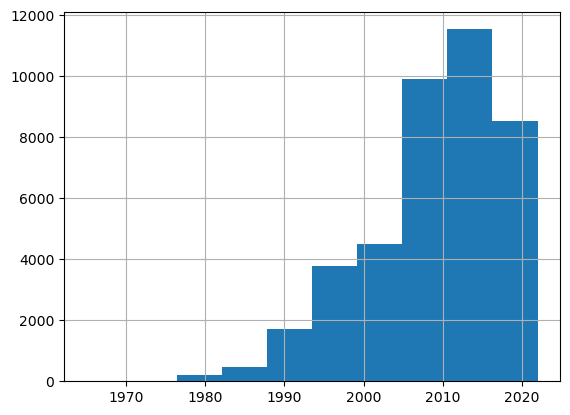

In [78]:
# Note, that most articles have more measuremetns in them
df_dois['year'].hist()